# The Language of Kickstarter

## Objective
Kickstarter has defined 15 categories of projects i.e. Art, Comics, Crafts, Dance, Design, Fashion, Film & Video, Food, Games, Journalism, Music, Photography, Publishing, Technology, and Theater.

The objective of my project is to using Natural Language Processing and Unsupervised Learning to analyze the the Kickstarter descriptions and to see whether
1. some new categories would emerge based on the language used
2. some categories would roll-up into some others

### Step 1: Data Acquisition 

Data was obtained by scraping the Kickstarter website using selenium.

In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import StaleElementReferenceException
import pandas as pd
import pickle
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# function to pickle an object to a file
def from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [4]:
# function to read a pickled object
def to_pickle(filename,objname):
    with open(filename, 'wb') as f:
        pickle.dump(objname, f)

The first step in web scraping is to open a chrome browser and get the page from where you want to scrape the information.

In [5]:
chromedriver_path = "/Users/Jayalakshmi/chromedriver"
driver = webdriver.Chrome(chromedriver_path)
driver.get('https://www.kickstarter.com/discover/advanced?ref=discovery_overlay')
time.sleep(2); 

The page we load up looks like this:
<br>
<img src="images/kickstarter_land.png">

So, the plan is to get the links for each project on this page, store them in a dictionary and later open up each link and scrape the details.  
<br>
The initial page just loads up 12 projects.  
<br>
On scrolling down, we will notice a LOAD MORE button.
<img src="images/load_more.png">
<br>
The code in the next cell shows how to click the button.

In [8]:
load_more = driver.find_element_by_xpath('//a[@class="btn btn--border-gray type-12"]')
load_more.click()
time.sleep(5) 

This website has an infinite scrolling feature like we see on a Facebook timelinei.e. as we approach the bottom of the page, more projects get loaded and when we get to the bottom of that, even more get loaded. This goes on till there is no more content to load. Using the code below, we can load upto 3000 projects.

In [ ]:
SCROLL_PAUSE_TIME = 3.0

# Get scroll height
last_height = driver.execute_script("return document.body.scrollHeight")

while True:
    # Scroll down to bottom
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # Wait to load page
    time.sleep(SCROLL_PAUSE_TIME)

    # Calculate new scroll height and compare with last scroll height
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

Once 3000 projects are loaded onto the screen, then we can go ahead and scrape their links and categories and store them in a dictionary.

In [ ]:
projects=[]

In [ ]:
project_category = driver.find_elements_by_xpath('//a[@class="navy-600"]')
project_link = driver.find_elements_by_xpath('//a[@class="block img-placeholder w100p"]')

for category, link in zip(project_category,project_link):
    ind_project={}
    ind_project['Category']=category.text
    ind_project['Link']=link.get_attribute('href')
    print (category.text)
    print (link.get_attribute('href'))
    projects.append(ind_project)

In [ ]:
to_pickle('kickstarter_dic.p',projects)

In [7]:
projects = from_pickle('kickstarter_dic.p')

In [8]:
len(projects)

3000

In [9]:
projects[:5]

[{'Category': u'Tabletop Games',
  'Link': u'https://www.kickstarter.com/projects/malachi-rempen/itchy-feet-the-travel-game?ref=discovery'},
 {'Category': u'Public Art',
  'Link': u'https://www.kickstarter.com/projects/1973271377/murals-across-america-flint?ref=discovery'},
 {'Category': u'Apparel',
  'Link': u'https://www.kickstarter.com/projects/1706599822/a-performance-rock-climbing-pant-with-a-modern-aes?ref=discovery'},
 {'Category': u'Art Books',
  'Link': u'https://www.kickstarter.com/projects/347008021/the-untamed-beastiary-a-field-guide-to-marvelous-m?ref=discovery'},
 {'Category': u'Drinks',
  'Link': u'https://www.kickstarter.com/projects/savethebarley/canvas-a-new-type-of-beverage-made-from-saved-grai?ref=discovery'}]

Now, open up each link and scrape the details. Scraped details include:
1. Title of the project
1. Blurb
1. Location where the project is based
1. Goal to be raised
1. Amount actually pledged 
1. No. of Backers
1. Description (this is the data that I am interested in)
1. Risks involved (Description and Risks were combined for the analysis)
1. Creator
1. Deadline

In [ ]:
i=0

In [ ]:
for project in projects:
    
    print (i)
    driver.get(project['Link'])
    time.sleep(2); 
    
    try:
        spans = driver.find_elements_by_xpath('//h2[@class="type-24 type-28-sm type-38-md navy-700 medium mb3"]')
        for span in spans:
            ;
        project['Title']=span.text
    except StaleElementReferenceException:
        continue
    
    spans = driver.find_elements_by_xpath('//p[@class="type-14 type-18-md navy-600 mb0"]')
    for span in spans:
        ;
    project['Blurb']=span.text
    
    spans = driver.find_elements_by_xpath('//a[@class="nowrap navy-700 flex items-center medium type-12"]')
    for span in spans[:1]:
        ;
    project['Location']=span.text
    
    spans = driver.find_elements_by_xpath('//div[@class="num nowrap"]')
    for span in spans:
        ;
    project['Goal']=span.get_attribute('data-goal')
    project['Pledged'] = span.get_attribute('data-pledged')
    
    spans = driver.find_elements_by_xpath('//div[@class="js-backers_count block type-16 type-24-md medium navy-700"]')
    for span in spans[:1]:
        ;
    project['Backers']=span.text
    
    description = ''
    spans = driver.find_elements_by_xpath('//div[@class="full-description js-full-description responsive-media formatted-lists"]/ul')
    for span in spans:
        description=description + span.text +' '
    project['Description']=description

    risks=''
    spans = driver.find_elements_by_xpath('//div[@class="mb3 mb10-sm mb3 js-risks"]/p')
    for span in spans:
        risks=risks + span.text +' '
    project['Risks']=risks
    
    spans = driver.find_elements_by_xpath('//a[@class="medium navy-700 remote_modal_dialog"]')
    for span in spans:
        print(span.text)
    project['Creator']=span.text

    spans = driver.find_elements_by_xpath('//p[@class="mb3 mb0-lg type-12"]/time')
    for span in spans:
        ;
    project['Deadline']=span.get_attribute('datetime')
    
    time.sleep(5)
    i=i+1

In [ ]:
to_pickle('kickstarter_full_data.p',projects)

In [10]:
projects=from_pickle('kickstarter_full_data.p')

Not all the pages were uniformly structured. Some of them didn't have have the information under the same html tags as most pages. These projects are removed.

In [12]:
keep = [project for project in projects if len(project)>10]

In [13]:
len(keep)

2972

In [14]:
df = pd.DataFrame(keep)

In [15]:
df.head()

,Backers,Blurb,Category,Creator,Deadline,Description,Goal,Link,Location,Pledged,Risks,Title
0,"1,552","The simple, humorous and social travel-themed ...",Tabletop Games,Malachi Ray Rempen,2017-08-30T16:54:00-04:00,We've also put up a robust o...,10000.0,https://www.kickstarter.com/projects/malachi-r...,"Berlin, Germany",45678.25,"The game is finished and ready to go, so I'm c...",Itchy Feet: the Travel Game
1,86,Collaborative Community Mural Project,Public Art,Inga Loyeva,2017-09-12T15:23:44-04:00,783 million people worldwide lack access to cl...,14500.0,https://www.kickstarter.com/projects/197327137...,"Flint, MI",12045.0,The greatest challenge as an artist is managin...,Murals Across America: Flint
2,412,A performance rock climbing pant designed to c...,Apparel,Wear Foehn,2017-08-20T11:52:09-04:00,...,10000.0,https://www.kickstarter.com/projects/170659982...,"Quebec, Canada",71225.0,"Unlike many other Kickstarter projects, our fi...",THE BRISE PANT : A modern rock climbing pant.
3,406,Embark on a journey filled with monsters and b...,Art Books,Crystal Sully,2017-09-09T12:29:59-04:00,Growing up as an adventurous kid I u...,7535.0,https://www.kickstarter.com/projects/347008021...,"Denver, CO",26025.0,As a two-person team this project has a lot of...,The Untamed Beastiary: A Field Guide to Marvel...
4,405,"Canvas is the first sustainable, plant-based b...",Drinks,Canvas,2017-08-31T20:00:00-04:00,Our story begins with the production of one ...,25000.0,https://www.kickstarter.com/projects/savetheba...,"New York, NY",41845.0,Our team is committed to manufacturing the hig...,CANVAS: A Revolutionary New Beverage Made from...


In [ ]:
to_pickle('kickstarter_df.p',df)

In [9]:
kickstarter_df = from_pickle('kickstarter_df.p')

In [10]:
len(kickstarter_df.Category.unique())

148

The categories scraped were actually subcategories and takes on 148 unique values. Thats a lot to handle with since my objective also revolves around the project categories. 
<br>
So, I found the super categories for them on Kickstarter, which would take just 15 unique values and this information was added to the dataframe.

In [11]:
art = ["Ceramics", "Conceptual Art", "Digital Art", "Illustration", "Installations", "Mixed Media", "Painting", "Performance Art", "Public Art", "Sculpture", "Textiles", "Video Art", "Art"]

comics = ["Comics", "Anthologies", "Webcomics", "Comic Books", "Events", "Graphic Novels"]

crafts = ["Crafts", "Candles", "DIY", "Glass", "Printing", "Knitting", "Pottery", "Quilts", "Stationery", "Woodworking"]

dance = ["Dance", "Experimental", "Performances", "Spaces", "Workshops"]

design = ["Design", "Architecture", "Civic Design", "Interactive Design", "Graphic Design", "Product Design", "Technology", "Typography"]

fashion = ["Fashion", "Accessories", "Apparel", "Childrenswear", "Couture", "Footwear", "Jewelry", "Ready-to-wear"]

film_video = ["Film & Video", "Action", "Animation", "Comedy", "Documentary", "Drama", "Family", "Fantasy", "Festivals", "Horror", "Movie Theaters", "Music Videos", "Narrative Film", "Romance", "Science Fiction", "Shorts", "Television", "Thrillers", "Webseries" ]

food = ["Food", "Community Gardens", "Cookbooks", "Farmer's Markets", "Drinks", "Farms", "Food Trucks", "Restaurants", "Small Batch", "Vegan"]

games = ["Tabletop Games", "Video Games", "Games", "Playing Cards", "Live Games", "Mobile Games", "Gaming Hardware"]

journalism = ["Journalism", "Audio", "Print", "Video", "Web"]

music = ["Music", "Latin", "Blues", "Punk", "Metal", "Jazz", "Classical Music", "Country & Folk", "Electronic Music", "Faith", "Hip-Hop", "Pop", "Indie Rock", "Kids", "R&B", "Rock", "World Music"]

photography = ["Photography", "Animals", "Fine Art", "People", "Nature", "Photobooks", "Places"]

publishing = ["Publishing", "Academic", "Art Books", "Calendars", "Children's Books", "Fiction", "Letterpress", "Literary Journals", "Nonfiction", "Periodicals", "Poetry", "Radio & Podcasts", "Translations", "Young Adult", "Zines"]

technology = ["Apps", "Gadgets", "Hardware", "Software", "Wearables", "Camera Equipment", "3D Printing", "Makerspaces", "Flight", "Space Exploration", "Fabrication Tools", "Robots", "Sound", "DIY Electronics"]

theater = ["Theater", "Musical", "Plays" , "Immersive"]

In [12]:
for sub_category in art:
    kickstarter_df.loc[kickstarter_df['Category']==sub_category,'Category']= "Art"

for sub_category in comics:
    kickstarter_df.loc[kickstarter_df['Category']==sub_category,'Category']= "Comics"
    
for sub_category in crafts:
    kickstarter_df.loc[kickstarter_df['Category']==sub_category,'Category']= "Crafts"

for sub_category in dance:
    kickstarter_df.loc[kickstarter_df['Category']==sub_category,'Category']= "Dance"

for sub_category in design:
    kickstarter_df.loc[kickstarter_df['Category']==sub_category,'Category']= "Design"

for sub_category in fashion:
    kickstarter_df.loc[kickstarter_df['Category']==sub_category,'Category']= "Fashion"

for sub_category in film_video:
    kickstarter_df.loc[kickstarter_df['Category']==sub_category,'Category']= "Film & Video"
    
for sub_category in food:
    kickstarter_df.loc[kickstarter_df['Category']==sub_category,'Category']= "Food"

for sub_category in games:
    kickstarter_df.loc[kickstarter_df['Category']==sub_category,'Category']= "Games"

for sub_category in journalism:
    kickstarter_df.loc[kickstarter_df['Category']==sub_category,'Category']= "Journalism"

for sub_category in music:
    kickstarter_df.loc[kickstarter_df['Category']==sub_category,'Category']= "Music"

for sub_category in photography:
    kickstarter_df.loc[kickstarter_df['Category']==sub_category,'Category']= "Photography"

for sub_category in publishing:
    kickstarter_df.loc[kickstarter_df['Category']==sub_category,'Category']= "Publishing"
    
for sub_category in technology:
    kickstarter_df.loc[kickstarter_df['Category']==sub_category,'Category']= "Technology"
    
for sub_category in theater:
    kickstarter_df.loc[kickstarter_df['Category']==sub_category,'Category']= "Theater"

In [13]:
values = []
categories = []
for row, val in zip(kickstarter_df.Category.value_counts().index,kickstarter_df.Category.value_counts()):
    values.append(val)
    categories.append(row)

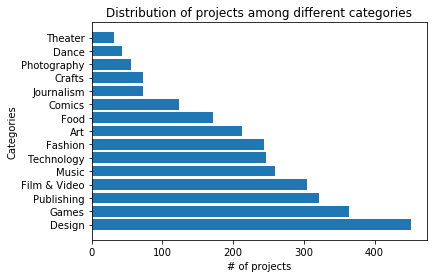

In [14]:
plt.figure()

plt.barh(np.arange(len(categories)), values)

plt.yticks(np.arange(len(categories)),
           [category for category in categories]);
plt.xlabel("# of projects")
plt.ylabel('Categories')
plt.title("Distribution of projects among different categories")

In [ ]:
kickstarter_df['State/Country'] = kickstarter_df.Location.str.split(',').str[1]

In [35]:
kickstarter_df['State/Country'].value_counts()

 CA                         350
 UK                         303
 NY                         189
 Canada                     126
 TX                         119
 FL                         110
 AU                         100
 Mexico                      82
 IL                          79
 WA                          65
 PA                          62
 OH                          60
 GA                          55
 Germany                     53
 CO                          52
 UT                          48
 Italy                       47
 NC                          47
 OR                          45
 NJ                          43
 TN                          41
 VA                          37
 AZ                          35
 Hong Kong                   34
 MA                          33
 MN                          31
 Spain                       31
 France                      30
 MI                          29
 NV                          29
                           ... 
 Philipp

In [32]:
to_pickle('kickstarter_df_clean.p',kickstarter_df)

In [33]:
kickstarter_df = from_pickle('kickstarter_df_clean.p')

In [34]:
kickstarter_df.head()

,Backers,Blurb,Category,Creator,Deadline,Description,Goal,Link,Location,Pledged,Risks,Title,State/Country
0,"1,552","The simple, humorous and social travel-themed ...",Games,Malachi Ray Rempen,2017-08-30T16:54:00-04:00,We've also put up a robust o...,10000.0,https://www.kickstarter.com/projects/malachi-r...,"Berlin, Germany",45678.25,"The game is finished and ready to go, so I'm c...",Itchy Feet: the Travel Game,Germany
1,86,Collaborative Community Mural Project,Art,Inga Loyeva,2017-09-12T15:23:44-04:00,783 million people worldwide lack access to cl...,14500.0,https://www.kickstarter.com/projects/197327137...,"Flint, MI",12045.0,The greatest challenge as an artist is managin...,Murals Across America: Flint,MI
2,412,A performance rock climbing pant designed to c...,Fashion,Wear Foehn,2017-08-20T11:52:09-04:00,...,10000.0,https://www.kickstarter.com/projects/170659982...,"Quebec, Canada",71225.0,"Unlike many other Kickstarter projects, our fi...",THE BRISE PANT : A modern rock climbing pant.,Canada
3,406,Embark on a journey filled with monsters and b...,Publishing,Crystal Sully,2017-09-09T12:29:59-04:00,Growing up as an adventurous kid I u...,7535.0,https://www.kickstarter.com/projects/347008021...,"Denver, CO",26025.0,As a two-person team this project has a lot of...,The Untamed Beastiary: A Field Guide to Marvel...,CO
4,405,"Canvas is the first sustainable, plant-based b...",Food,Canvas,2017-08-31T20:00:00-04:00,Our story begins with the production of one ...,25000.0,https://www.kickstarter.com/projects/savetheba...,"New York, NY",41845.0,Our team is committed to manufacturing the hig...,CANVAS: A Revolutionary New Beverage Made from...,NY
